# NLP Assignment 2 

In [24]:
import pandas as pd
import json
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Loading the dataset

### ATIS

In [13]:

splits = {
    'train': 'atis_train.csv',
    'test': 'atis_test.csv'
}

In [14]:
atis_train = pd.read_csv("hf://datasets/tuetschek/atis/" + splits["train"])
atis_test = pd.read_csv("hf://datasets/tuetschek/atis/" + splits["test"])

print("ATIS Train shape:", atis_train.shape)
print("ATIS Test shape:", atis_test.shape)
print(atis_train.head())

d:\CodingPlayground\NLP\Assignment_2\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ATIS Train shape: (4978, 4)
ATIS Test shape: (893, 4)
   id       intent                                               text  \
0   0       flight  i want to fly from boston at 838 am and arrive...   
1   1       flight  what flights are available from pittsburgh to ...   
2   2  flight_time  what is the arrival time in san francisco for ...   
3   3      airfare            cheapest airfare from tacoma to orlando   
4   4      airfare  round trip fares from pittsburgh to philadelph...   

                                               slots  
0  O O O O O B-fromloc.city_name O B-depart_time....  
1  O O O O O B-fromloc.city_name O B-toloc.city_n...  
2  O O O B-flight_time I-flight_time O B-fromloc....  
3  B-cost_relative O O B-fromloc.city_name O B-to...  
4  B-round_trip I-round_trip O O B-fromloc.city_n...  


### Saving the data locally

In [16]:

os.makedirs("Data/ATIS", exist_ok=True)

# Save ATIS datasets to CSV files
atis_train.to_csv("Data/ATIS/atis_train.csv", index=False)
atis_test.to_csv("Data/ATIS/atis_test.csv", index=False)

print("ATIS datasets saved successfully!")
print("- Train dataset saved to: Data/ATIS/atis_train.csv")
print("- Test dataset saved to: Data/ATIS/atis_test.csv")

ATIS datasets saved successfully!
- Train dataset saved to: Data/ATIS/atis_train.csv
- Test dataset saved to: Data/ATIS/atis_test.csv


### SLURP

In [ ]:

def load_jsonl(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data


In [5]:

slurp_train = load_jsonl("slurp_1/train.jsonl")
slurp_dev = load_jsonl("slurp_1/devel.jsonl")
slurp_test = load_jsonl("slurp_1/test.jsonl")
slurp_train_synth = load_jsonl("slurp_1/train_synthetic.jsonl")

print("SLURP Train size:", len(slurp_train))
print("Example SLURP entry:", slurp_train[0])

SLURP Train size: 11514
Example SLURP entry: {'slurp_id': 9024, 'sentence': 'event', 'sentence_annotation': 'event', 'intent': 'calendar_set', 'action': 'set', 'tokens': [{'surface': 'event', 'id': 0, 'lemma': 'event', 'pos': 'NN'}], 'scenario': 'calendar', 'recordings': [{'file': 'audio-1501754435.flac', 'wer': 0.0, 'ent_wer': None, 'status': 'correct'}, {'file': 'audio-1501407267-headset.flac', 'wer': 0.0, 'ent_wer': None, 'status': 'correct'}, {'file': 'audio-1501407267.flac', 'wer': 0.0, 'ent_wer': None, 'status': 'correct'}, {'file': 'audio-1501771798-headset.flac', 'wer': 0.0, 'ent_wer': None, 'status': 'correct'}, {'file': 'audio-1501771798.flac', 'wer': 0.0, 'ent_wer': None, 'status': 'correct'}, {'file': 'audio-1490705711-headset.flac', 'wer': 0.0, 'ent_wer': None, 'status': 'correct'}, {'file': 'audio-1490705711.flac', 'wer': 0.0, 'ent_wer': None, 'status': 'correct'}, {'file': 'audio-1494416970-headset.flac', 'wer': 0.0, 'ent_wer': None, 'status': 'correct'}, {'file': 'audio

### removing the excess fields from the data and converting entities to BIO strings for slot prediction

### To convert entities field to BIO String

In [18]:
def entities_to_bio(tokens, entities):
    """
    tokens: list of token dicts, each has "surface" etc.
    entities: list of dicts, each with "span" (list of token indices) and "type"
    Returns: list of BIO slot labels (strings), same length as tokens
    """
    T = len(tokens)
    bio = ["O"] * T
    for ent in entities:
        span = ent["span"]
        stype = ent["type"]
        if not span:
            continue
        # First token in span gets B-
        first = span[0]
        bio[first] = f"B-{stype}"
        # If span has more tokens, label them I-
        for idx in span[1:]:
            bio[idx] = f"I-{stype}"
    return bio

### Preproces raw slurp jsons to csv with BIO strings for slot prediction

In [19]:
def process_slurp_jsonl_to_csv(input_jsonl_paths, output_csv_path):
    """
    input_jsonl_paths: list of paths (train, dev, test, etc.)
    output_csv_path: path to write the combined CSV
    """
    
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

    
    csv_columns = ["slurp_id", "sentence", "intent", "entities", "slot_string"]
    
   
    with open(output_csv_path, 'w', encoding='utf-8', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        
        for jp in input_jsonl_paths:
            data = load_jsonl(jp)
            for rec in data:
                slurp_id = rec.get("slurp_id")
                sentence = rec.get("sentence")
                intent = rec.get("intent")
                entities = rec.get("entities", [])
                tokens = rec.get("tokens", [])
                
                # Build BIO slot string
                bio_labels = entities_to_bio(tokens, entities)
                # Join them with space (or some delimiter)
                slot_string = " ".join(bio_labels)
                
                # Prepare minimal record
                out = {
                    "slurp_id": slurp_id,
                    "sentence": sentence,
                    "intent": intent,
                    # We convert entities list to JSON string so we can store in CSV
                    "entities": json.dumps(entities, ensure_ascii=False),
                    "slot_string": slot_string
                }
                writer.writerow(out)

    print("Saved to CSV:", output_csv_path)

In [20]:
mapping = [
        ("slurp_1/train.jsonl",   "Data/SLURP/slurp_train.csv"),
        ("slurp_1/devel.jsonl",   "Data/SLURP/slurp_dev.csv"),
        ("slurp_1/test.jsonl",    "Data/SLURP/slurp_test.csv"),
        ("slurp_1/train_synthetic.jsonl", "Data/SLURP/slurp_train_synth.csv"),
    ]


In [21]:
for in_path, out_csv in mapping:
    process_slurp_jsonl_to_csv([in_path], out_csv)

Saved to CSV: Data/SLURP/slurp_train.csv
Saved to CSV: Data/SLURP/slurp_dev.csv
Saved to CSV: Data/SLURP/slurp_test.csv
Saved to CSV: Data/SLURP/slurp_train_synth.csv


### Exploratory Data Analysis

### SLURP

In [22]:


df = pd.read_csv("Data/SLURP/slurp_train.csv")

# Basic statistics
print("Num utterances:", len(df))
print("Num unique intents:", df["intent"].nunique())
print("Intents counts:\n", df["intent"].value_counts().head(10))



Num utterances: 11514
Num unique intents: 91
Intents counts:
 intent
calendar_set       804
play_music         620
weather_query      559
calendar_query     558
general_quirky     546
qa_factoid         535
news_query         500
email_query        415
email_sendemail    347
datetime_query     342
Name: count, dtype: int64


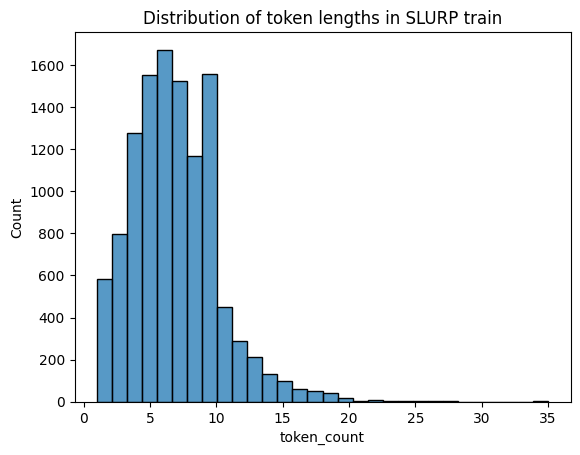

In [25]:
# Sentence length distribution
df["token_count"] = df["sentence"].str.split().map(len)
sns.histplot(df["token_count"], bins=30)
plt.title("Distribution of token lengths in SLURP train")
plt.show()



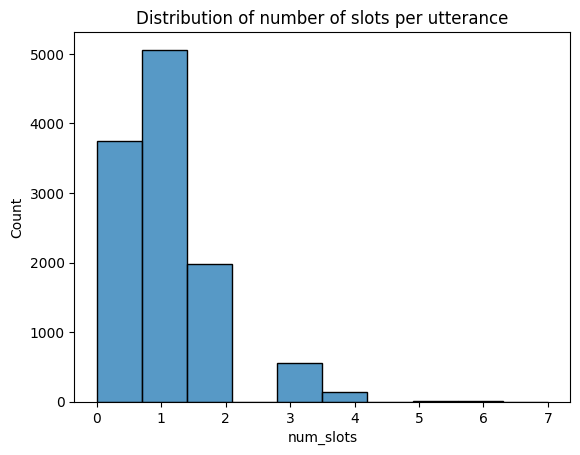

In [26]:
 # Slots per utterance
def count_slots(slot_string):
    if pd.isna(slot_string):
        return 0
    labels = slot_string.split()
    # count B- tags
    return sum(1 for lab in labels if lab.startswith("B-"))
df["num_slots"] = df["slot_string"].apply(count_slots)
sns.histplot(df["num_slots"], bins=10)
plt.title("Distribution of number of slots per utterance")
plt.show()


In [30]:
def plot_top_slot_labels(cnt, top_n=20):
    # Plot the top slot label counts (B/I)
    most = cnt.most_common(top_n)
    labels, freqs = zip(*most)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(freqs), y=list(labels), palette="viridis")  # horizontal bars
    plt.xlabel("Count")
    plt.ylabel("Slot Label (B-/I-)")
    plt.title(f"Top {top_n} Slot Labels (with BIO prefixes)")
    plt.tight_layout()
    plt.show()

def plot_slot_types(cnt2, top_n=20):
    most = cnt2.most_common(top_n)
    types_, freqs = zip(*most)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(freqs), y=list(types_), palette="coolwarm")
    plt.xlabel("Count")
    plt.ylabel("Slot Type")
    plt.title(f"Top {top_n} Slot Types (BIO merged)")
    plt.tight_layout()
    plt.show()

def plot_slot_type_pie(cnt2, top_n=10):
    # Pie chart of top slot types, remainder grouped into “Other”
    most = cnt2.most_common(top_n)
    types_, freqs = zip(*most)
    total = sum(cnt2.values())
    other = total - sum(freqs)
    
    labels = list(types_) + ["Other"]
    sizes = list(freqs) + [other]
    
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Slot Type Proportions (top + Other)")
    plt.axis('equal')  # equal aspect ensures pie is circular
    plt.show()



In [27]:

# Slot type frequencies
all_slot_labels = []
for ss in df["slot_string"].dropna():
    for lab in ss.split():
        if lab != "O":
            all_slot_labels.append(lab)
cnt = Counter(all_slot_labels)
print("Top slot labels:", cnt.most_common(20))
# e.g. distinct slot types by removing the B-/I- prefix
slot_types = [lab.split("-", 1)[1] for lab in all_slot_labels if "-" in lab]
cnt2 = Counter(slot_types)
print("Slot types frequency:", cnt2.most_common())


Top slot labels: [('B-date', 1823), ('B-place_name', 1088), ('B-event_name', 1000), ('I-time', 943), ('I-date', 906), ('B-person', 866), ('B-time', 799), ('I-event_name', 551), ('I-place_name', 527), ('B-media_type', 478), ('I-person', 413), ('B-business_name', 384), ('B-weather_descriptor', 320), ('B-transport_type', 318), ('B-food_type', 295), ('I-radio_name', 284), ('I-business_name', 252), ('B-relation', 251), ('B-timeofday', 239), ('B-artist_name', 232)]
Slot types frequency: [('date', 2729), ('time', 1742), ('place_name', 1615), ('event_name', 1551), ('person', 1279), ('business_name', 636), ('media_type', 575), ('food_type', 444), ('device_type', 424), ('radio_name', 416), ('weather_descriptor', 409), ('artist_name', 378), ('currency_name', 338), ('news_topic', 331), ('transport_type', 318), ('list_name', 306), ('relation', 304), ('definition_word', 304), ('song_name', 302), ('timeofday', 264), ('house_place', 258), ('business_type', 241), ('music_genre', 220), ('player_setting'

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12792\4065694706.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(labels), palette="viridis")  # horizontal bars


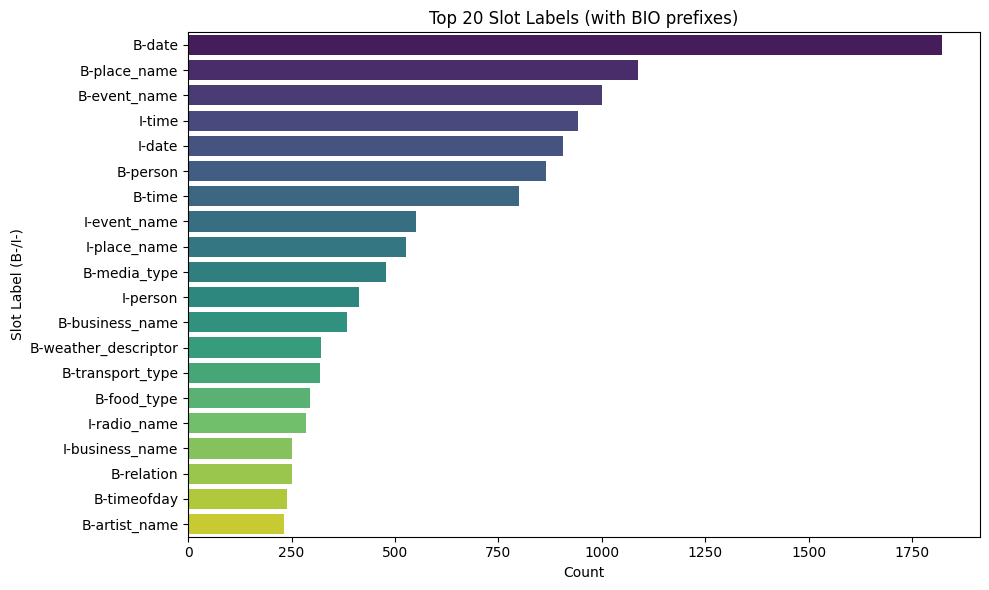

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12792\4065694706.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(types_), palette="coolwarm")


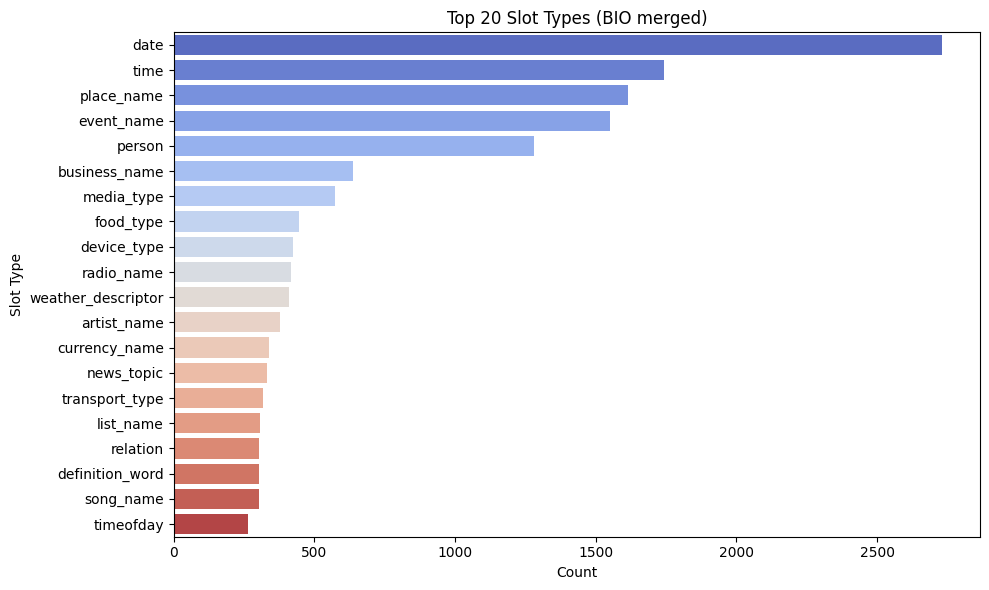

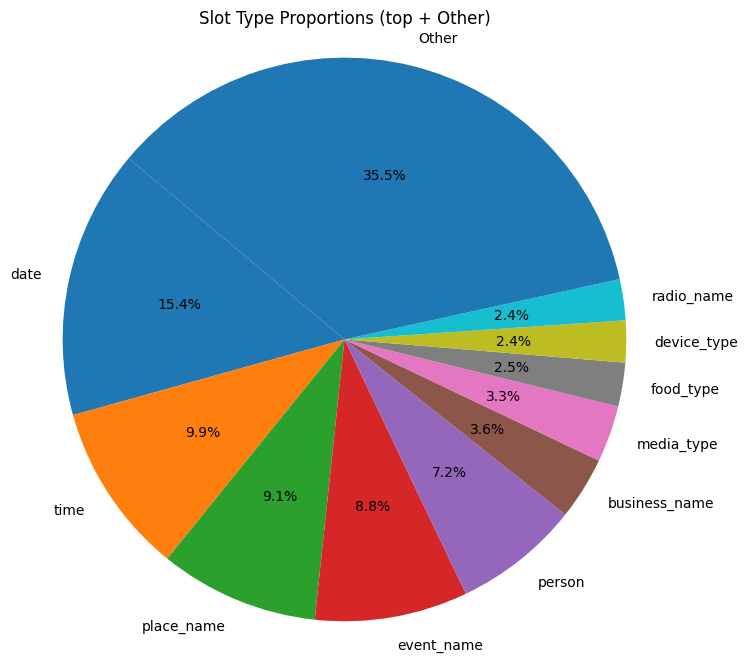

In [31]:
# Now call them
plot_top_slot_labels(cnt, top_n=20)
plot_slot_types(cnt2, top_n=20)
plot_slot_type_pie(cnt2, top_n=10)

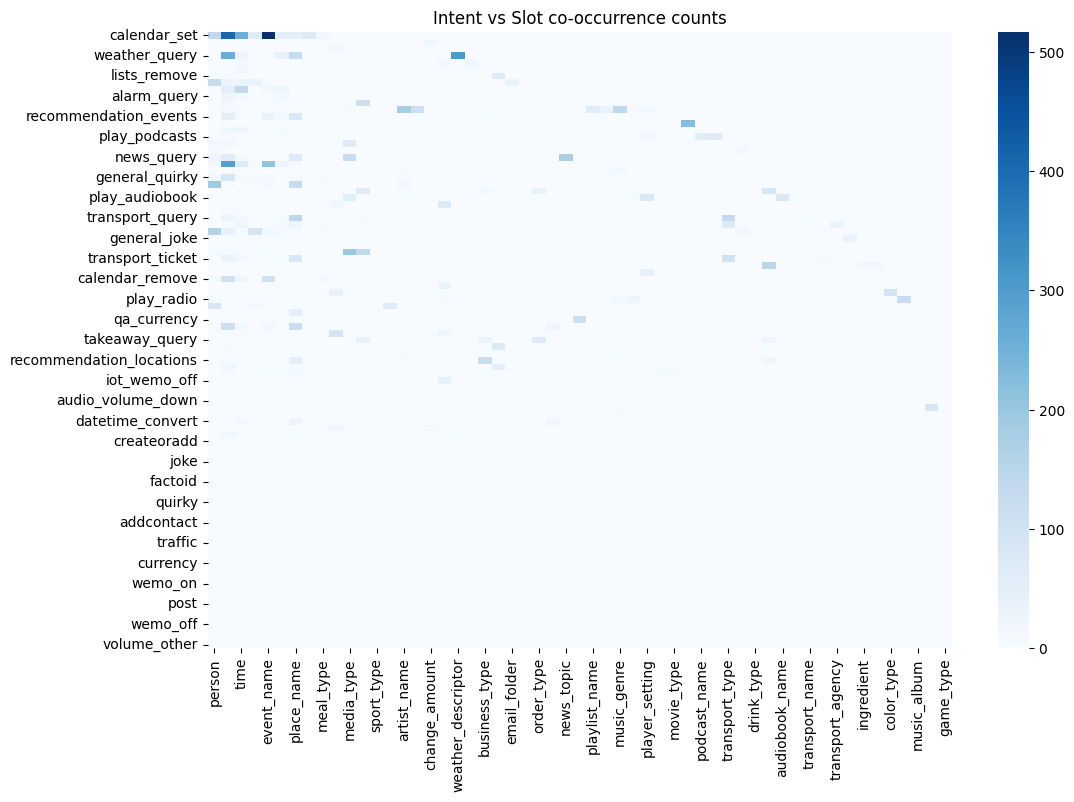

In [29]:

# Intent vs slot co-occurrence matrix
intent_slot = {}
for _, row in df.iterrows():
    intent = row["intent"]
    labels = row["slot_string"].split() if isinstance(row["slot_string"], str) else []
    types = set([lab.split("-",1)[1] for lab in labels if lab != "O" and "-" in lab])
    if intent not in intent_slot:
        intent_slot[intent] = Counter()
    intent_slot[intent].update(types)
# convert to DataFrame
mat = pd.DataFrame(intent_slot).fillna(0).T  # intents as rows, slot types as columns
plt.figure(figsize=(12,8))
sns.heatmap(mat, annot=False, cmap="Blues")
plt.title("Intent vs Slot co-occurrence counts")
plt.show()



In [28]:
# Compare train vs dev vs test
df_dev = pd.read_csv("Data/SLURP/slurp_dev.csv")
df_test = pd.read_csv("Data/SLURP/slurp_test.csv")

for split_df, name in [(df, "train"), (df_dev, "dev"), (df_test, "test")]:
    print(name, "avg tokens:", split_df["sentence"].str.split().map(len).mean(),
          "avg slots:", split_df["slot_string"].apply(count_slots).mean())

# Check how many utterances with no slots
for name, split_df in [("train", df), ("dev", df_dev), ("test", df_test)]:
    no_slot = (split_df["slot_string"].str.count("B-") == 0).sum()
    print(f"{name}: {no_slot} utterances with no slots, out of {len(split_df)}")


train avg tokens: 6.865641827340629 avg slots: 0.9872329338196978
dev avg tokens: 6.814067879980325 avg slots: 0.9945892769306444
test avg tokens: 6.771015467383995 avg slots: 0.949226630800269
train: 3755 utterances with no slots, out of 11514
dev: 646 utterances with no slots, out of 2033
test: 994 utterances with no slots, out of 2974
